/tmp/ipykernel_1838351/906424744.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Model loaded successfully.


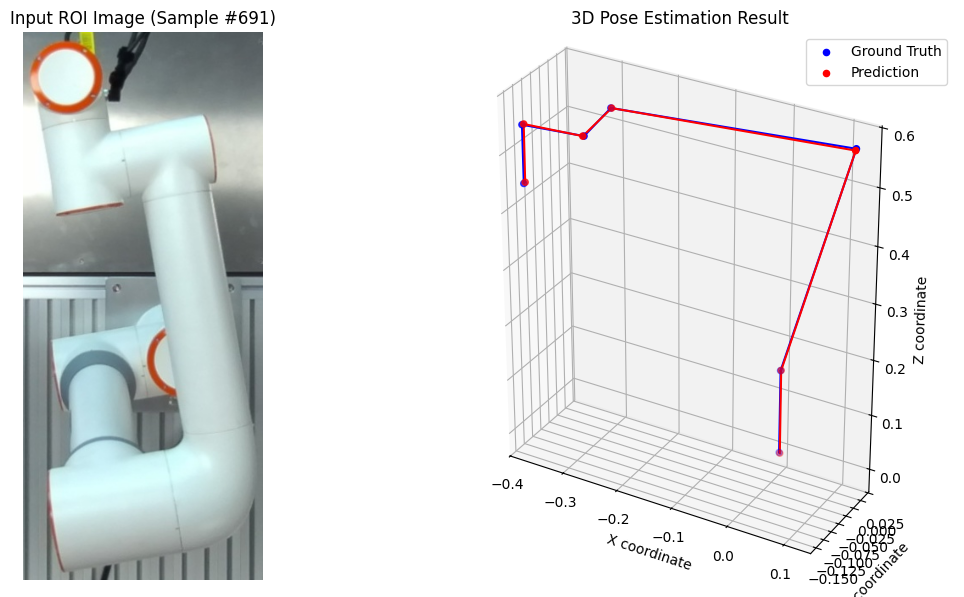

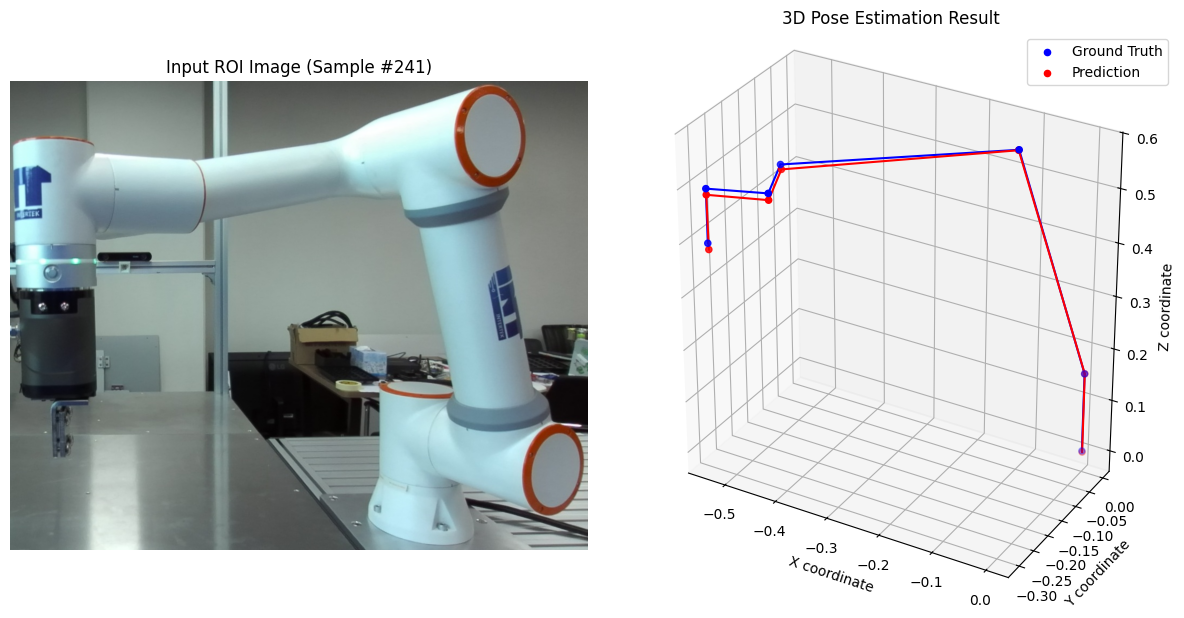

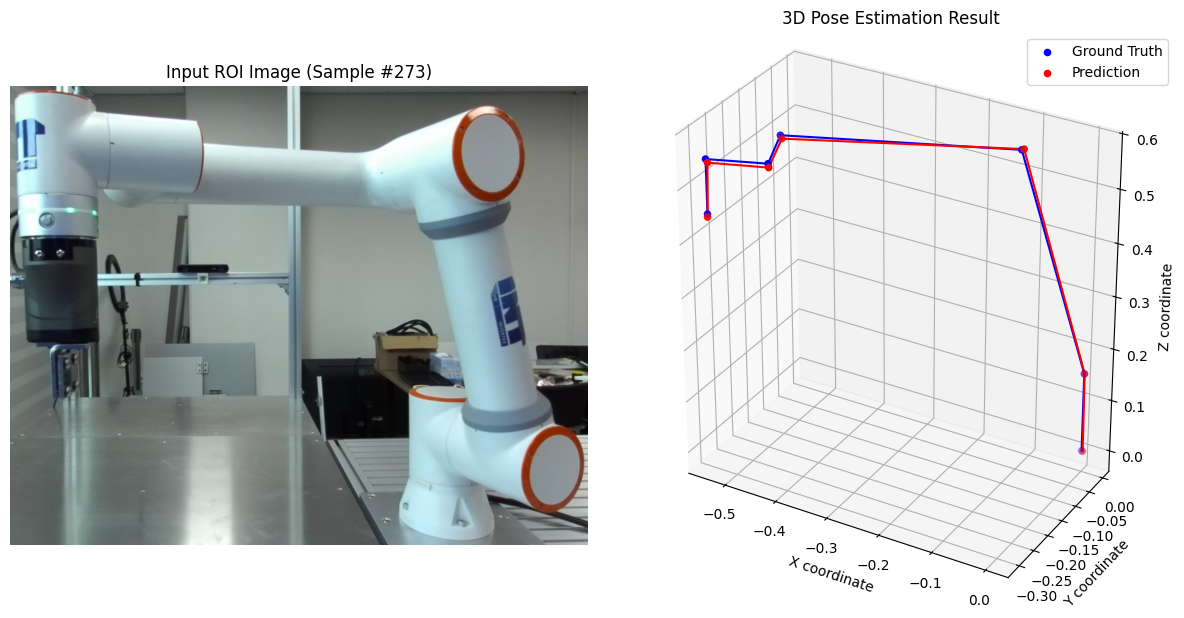

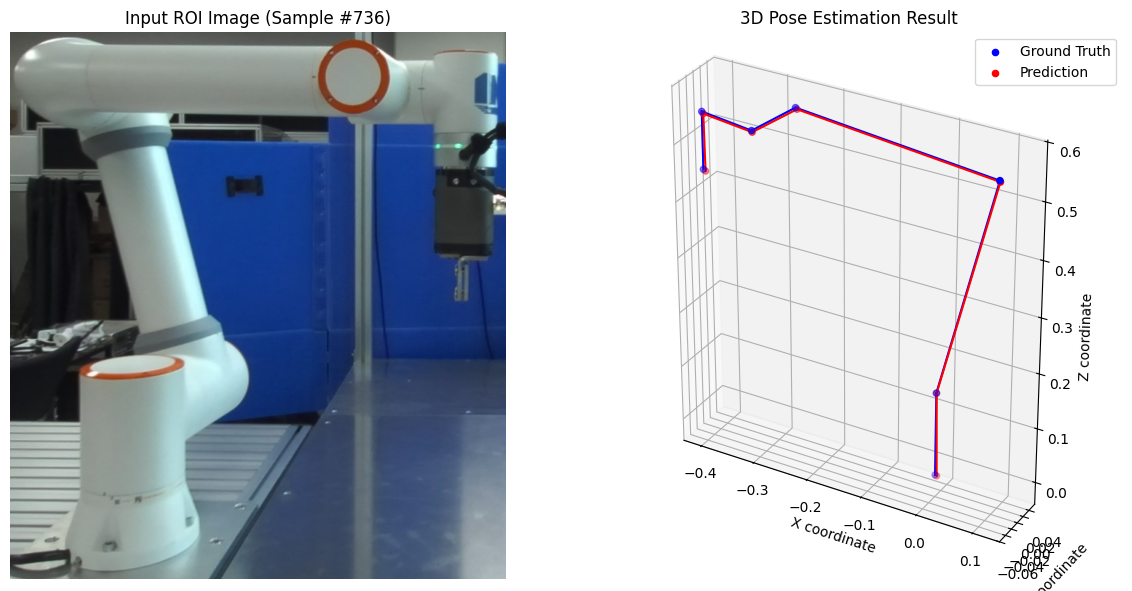

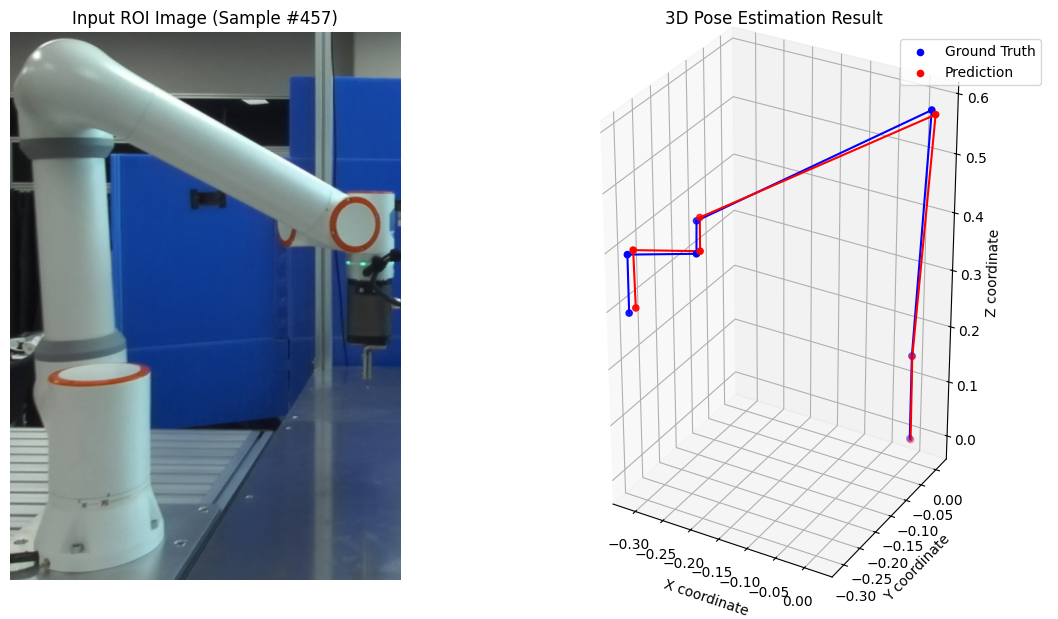

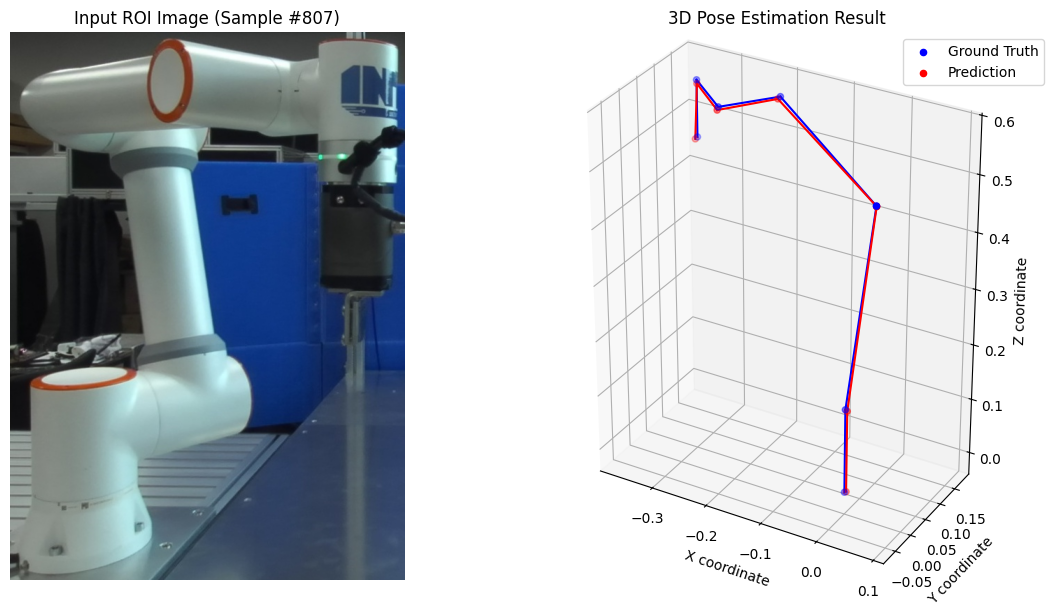

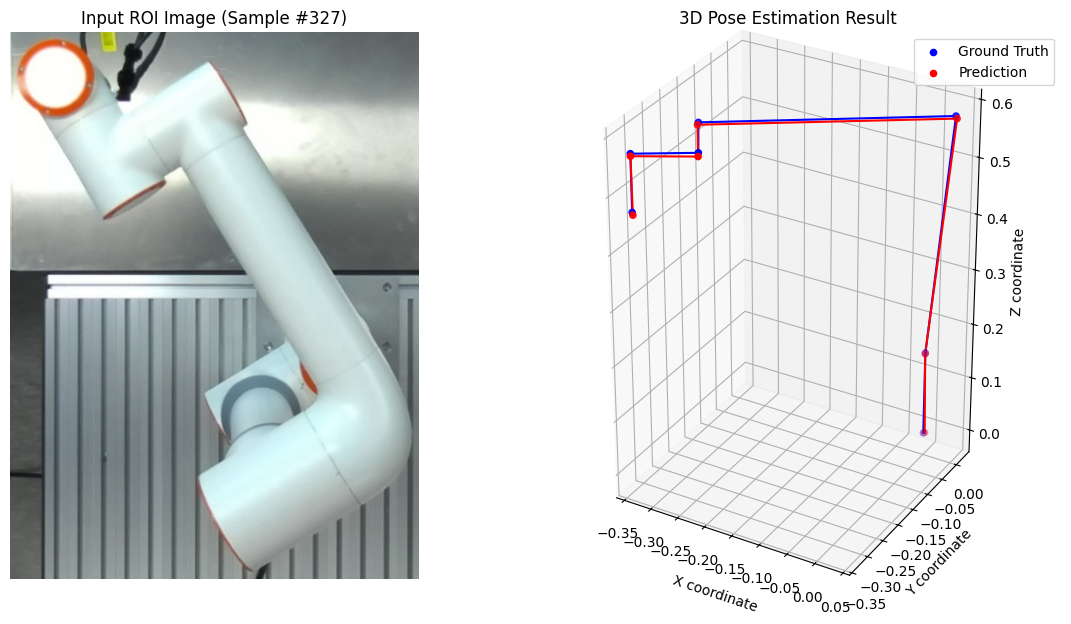

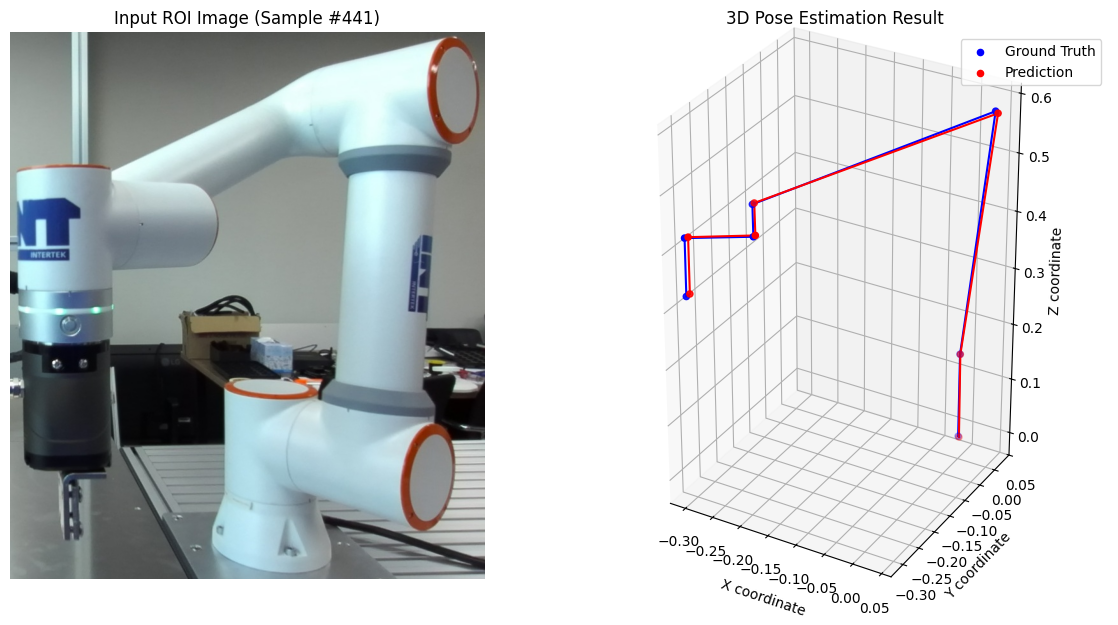

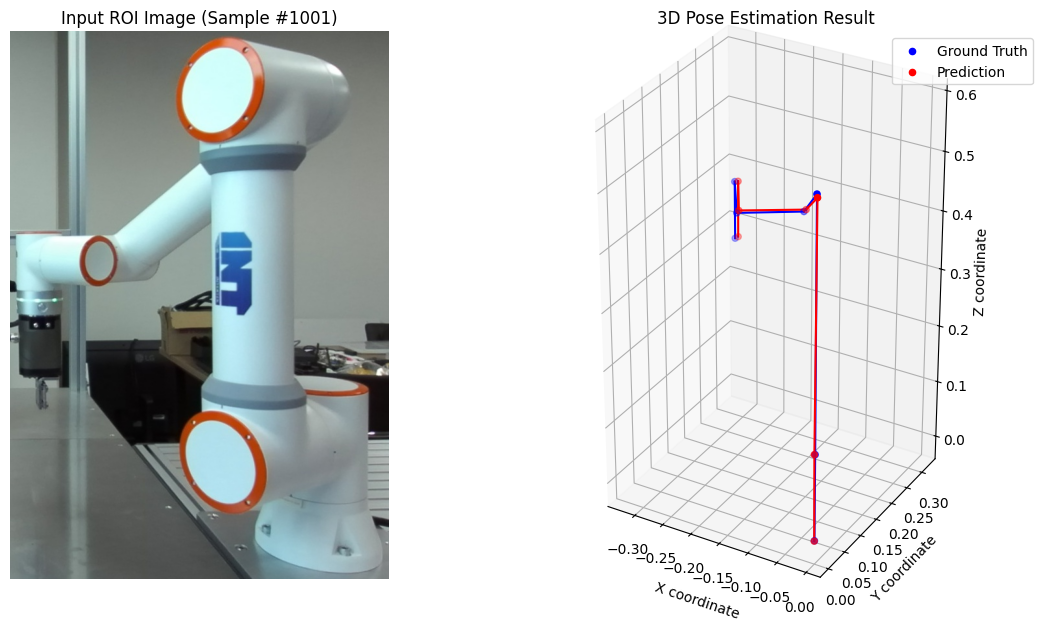

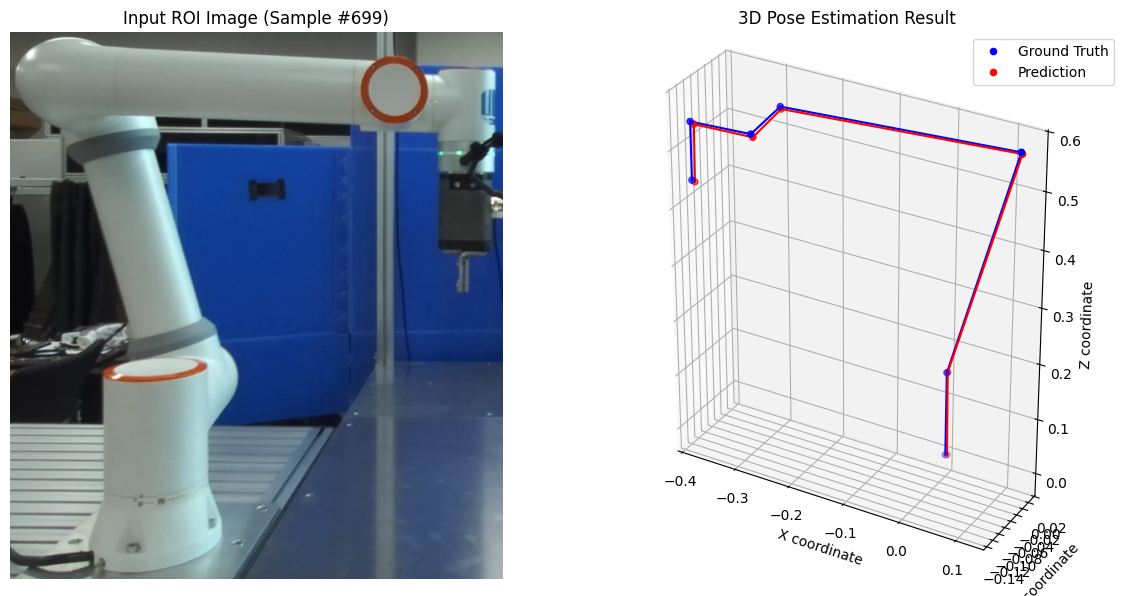

In [6]:
# =============== 주피터 노트북 환경 설정 ===============
%matplotlib inline
# ====================================================

import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 기존 프로젝트의 모델과 데이터셋 클래스를 가져옵니다.
# 'my_models.py'와 'my_datasets.py' 파일이 노트북과 동일한 디렉토리에 있거나
# 파이썬 경로에 추가되어 있어야 합니다.
from my_models import PoseEstimationSwinFPN
from my_datasets import RobotArmSegFKDataset

# ======================= 설정 =======================
# 학습된 최고 성능의 모델 가중치 경로
MODEL_PATH = "checkpoints_ddp_v2/box_best_model_checkpoint.pt" 

# 시각화에 사용할 CSV 파일 경로
VAL_CSV_PATH = os.path.join(
    "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset",
    "Fr5_intertek_7th_250526/matched_index_with_roi.csv"
)

# 시각화할 샘플 개수
NUM_SAMPLES_TO_VIZ = 10 

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 512
# ====================================================

def load_model(model_path, device):
    """DDP로 학습된 모델을 불러옵니다."""
    model = PoseEstimationSwinFPN(num_kp=7, img_size=IMG_SIZE)
    state_dict = torch.load(model_path, map_location=device)
    
    # DDP 'module.' 접두사 제거
    if all(key.startswith('module.') for key in state_dict.keys()):
        state_dict = {key.replace('module.', ''): value for key, value in state_dict.items()}
        
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print("Model loaded successfully.")
    return model

def plot_3d_pose(ax, points_3d, color, label, connections):
    """3D 스캐터 플롯에 로봇팔 스켈레톤을 그립니다."""
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c=color, marker='o', label=label)
    
    for start_idx, end_idx in connections:
        ax.plot(
            [points_3d[start_idx, 0], points_3d[end_idx, 0]],
            [points_3d[start_idx, 1], points_3d[end_idx, 1]],
            [points_3d[start_idx, 2], points_3d[end_idx, 2]],
            c=color
        )

# ================ 메인 실행 로직 ===================
# main() 함수 없이 노트북 셀에서 바로 실행합니다.

model = load_model(MODEL_PATH, DEVICE)
dataset = RobotArmSegFKDataset(
    index_paths=[VAL_CSV_PATH],
    image_size=IMG_SIZE
)

skeleton_connections = [
    (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)
]

# 데이터셋에서 랜덤으로 샘플 인덱스 선택
indices = np.random.choice(len(dataset), NUM_SAMPLES_TO_VIZ, replace=False)

for i in indices:
    sample = dataset[i]
    image_tensor = sample['image'].unsqueeze(0).to(DEVICE)
    gt_joints_xyz = sample['joints_xyz'].numpy()
    roi_path = sample['roi_path']

    with torch.no_grad():
        pred_joints_xyz = model(image_tensor).squeeze(0).cpu().numpy()

    # --- 수정: Figure를 생성하고 노트북에 바로 Plot ---
    fig = plt.figure(figsize=(12, 6))
    
    # 1. 원본 ROI 이미지 출력
    ax_img = fig.add_subplot(1, 2, 1)
    roi_image = cv2.imread(roi_path)
    ax_img.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))
    ax_img.set_title(f"Input ROI Image (Sample #{i})")
    ax_img.axis('off')

    # 2. 3D Pose 결과 출력
    ax_3d = fig.add_subplot(1, 2, 2, projection='3d')
    plot_3d_pose(ax_3d, gt_joints_xyz, 'blue', 'Ground Truth', skeleton_connections)
    plot_3d_pose(ax_3d, pred_joints_xyz, 'red', 'Prediction', skeleton_connections)
    
    ax_3d.set_xlabel('X coordinate')
    ax_3d.set_ylabel('Y coordinate')
    ax_3d.set_zlabel('Z coordinate')
    ax_3d.set_title("3D Pose Estimation Result")
    ax_3d.legend()
    # 3D 축의 스케일을 동일하게 맞추어 왜곡을 방지합니다.
    ax_3d.set_aspect('equal', 'box')

    plt.tight_layout()
    
    # --- 수정: 파일 저장 대신 화면에 출력 ---
    plt.show()

✅ Intrinsics loaded.
✅ Extrinsics loaded.


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Segmentation Model loaded.
✅ Pose Estimation Model loaded.

==================== Running Pipeline for: zed_30779426_left_1748249049.872.jpg ====================
Predicted joints: [[ 0.0038777   0.00226814  0.00499665]
 [ 0.00532274 -0.00188982  0.1432867 ]
 [ 0.03579026 -0.07214032  0.5494099 ]
 [-0.19578312  0.15294111  0.46132162]
 [-0.24124523  0.10513335  0.46657375]
 [-0.29472914  0.17044981  0.46597537]
 [-0.30316627  0.1603576   0.3809592 ]]

--- 🔎 파라미터 조회 시작: 'zed_30779426_left_1748249049.872.jpg' ---
  - 파일명 분석 결과:
    - view (Extrinsics용): 'top'
    - serial key (Intrinsics용): 'SN30779426'
    - side (Intrinsics용): 'left'
    - cam_name (Extrinsics용): 'leftcam'
  - 최종 조회 키:
    - Intrinsics: intrinsics['SN30779426']['left']
    - Extrinsics: extrinsics['top']['leftcam']
intr {'K': array([[1.07256e+03, 0.00000e+00, 1.12257e+03],
       [0.00000e+00, 1.07369e+03, 6.38972e+02],
       [0.00000e+00, 0.00000e+00, 1.00000e+00]], dtype=float32), 'D': array([-0.089292  ,  0.0928307

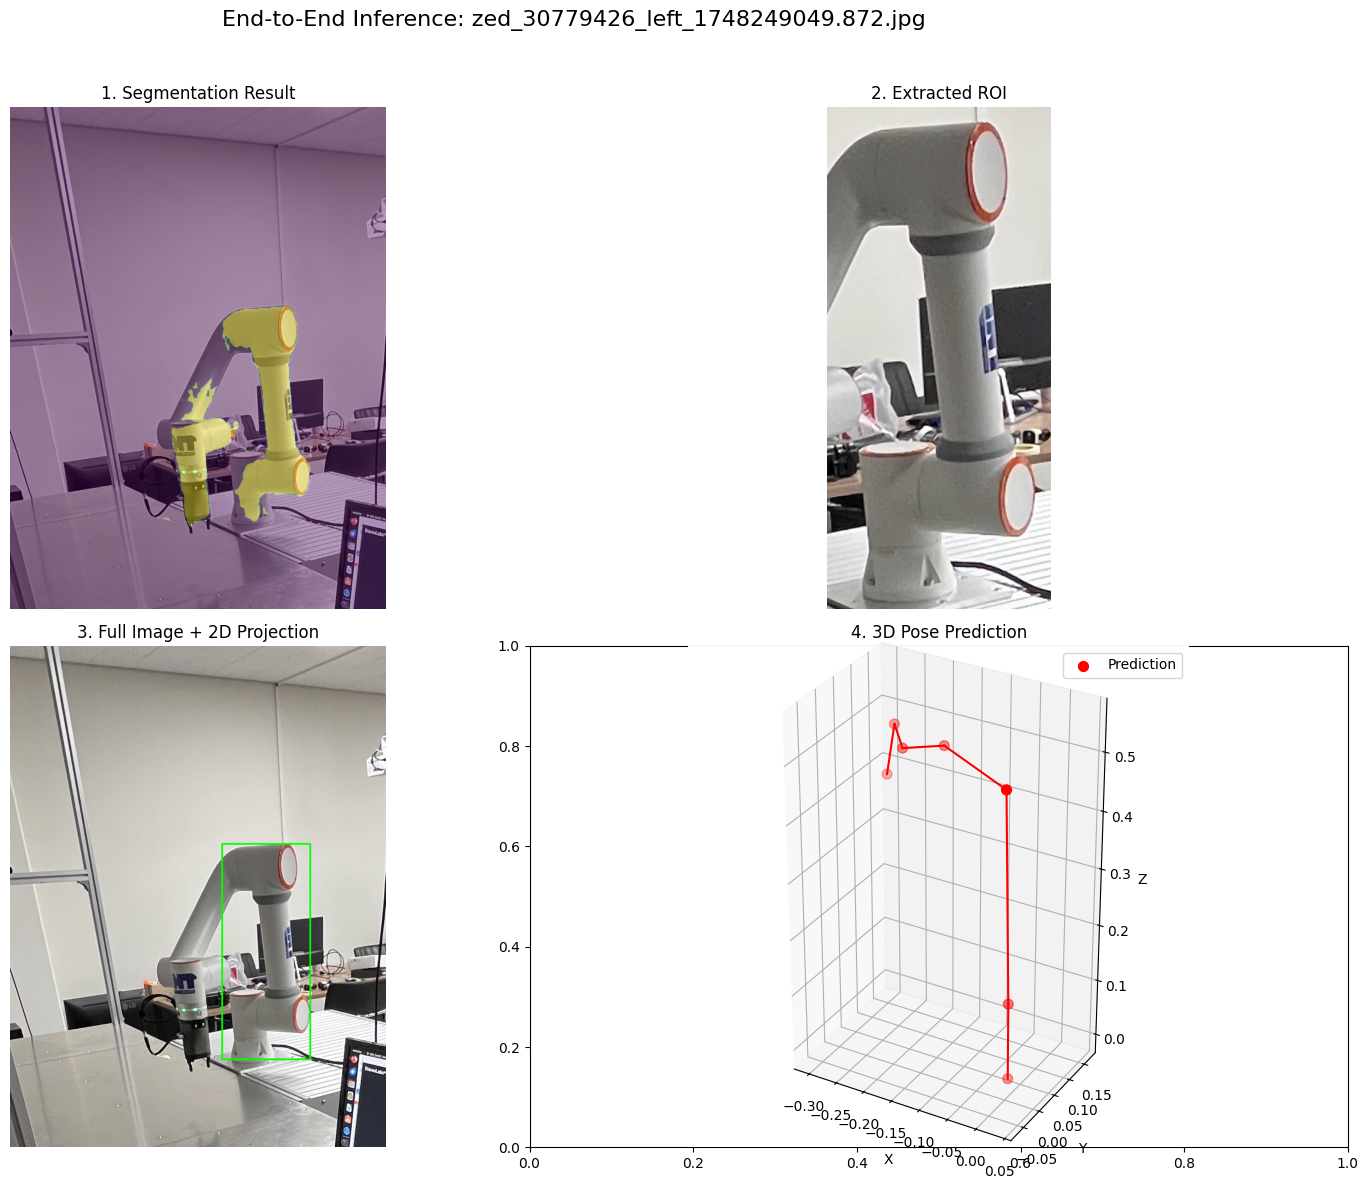

In [27]:
# =============== 주피터 노트북 환경 설정 ===============
%matplotlib inline

# =============== 1. 라이브러리 임포트 ===============
import os
import json
import configparser
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Any, Dict, List, Optional
from transformers import SegformerForSemanticSegmentation

import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- ✨ 사용자 정의 모듈 임포트 ✨ ---
# my_models.py에 PoseEstimationSwinFPN 클래스가 정의되어 있어야 합니다.
from my_models import PoseEstimationSwinFPN

# =============== 2. 설정 및 경로 지정 ===============
# --- 모델 경로 ---
POSE_MODEL_PATH = "checkpoints_ddp_v2/box_best_model_checkpoint.pt" 
SEG_MODEL_PATH = "/home/najo/NAS/DIP/Fr5_robot_SegFormer/best_segformer_robot_arm.pth"

# --- ✨ 추론할 새 이미지 경로 ✨ ---
NEW_IMAGE_PATH = "/home/najo/NAS/DIP/3d-robot-pose-estimation/zed_30779426_left_1748249049.872.jpg"

# --- 카메라 파라미터 경로 ---
INTRINSICS_CONF_FOLDER = "/home/najo/NAS/DIP/3d-robot-pose-estimation/camera_conf"
EXTRINSICS_JSON_PATH = "/home/najo/NAS/DIP/3d-robot-pose-estimation/ArUco_result_output/fr5_aruco_pose_summary.json"

# --- 기타 설정 ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 512
SKELETON_CONNECTIONS = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
CAMERA_SERIALS = {"right": "34850673", "left": "38007749", "top": "30779426"}


# =============== 3. 헬퍼 클래스 및 함수 정의 ===============

### ⚙️ 모델 클래스
class SegFormerForRobotArm(nn.Module):
    def __init__(self, num_classes=2, model_name="nvidia/mit-b2"):
        super().__init__()
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(
            model_name, num_labels=num_classes, ignore_mismatched_sizes=True
        )
    def forward(self, pixel_values):
        outputs = self.segformer(pixel_values=pixel_values)
        logits = F.interpolate(outputs.logits, size=pixel_values.shape[-2:], mode='bilinear', align_corners=False)
        return logits

### ⚙️ 유틸리티 함수
def mask_to_bbox(mask, min_area=100):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return None
    max_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(max_contour) < min_area: return None
    return cv2.boundingRect(max_contour)

def crop_with_padding(image, box, pad=20):
    x, y, w, h = box
    img_h, img_w = image.shape[:2]
    x1, y1 = max(0, x - pad), max(0, y - pad)
    x2, y2 = min(img_w, x + w + pad), min(img_h, y + h + pad)
    return image[y1:y2, x1:x2], (x1, y1)

### ⚙️ 모델 로딩 함수
def load_pose_model(model_path, device):
    model = PoseEstimationSwinFPN(num_kp=7, img_size=IMG_SIZE)
    state_dict = torch.load(model_path, map_location=device, weights_only=True)
    if any(key.startswith('module.') for key in state_dict.keys()):
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print("✅ Pose Estimation Model loaded.")
    return model

def load_seg_model(model_path, device):
    model = SegFormerForRobotArm(num_classes=2, model_name="nvidia/mit-b2").to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("✅ Segmentation Model loaded.")
    return model

### ⚙️ 카메라 파라미터 로딩 함수
def load_all_intrinsics(conf_folder_path: str):
    all_intrinsics = {}
    try:
        conf_files = [f for f in os.listdir(conf_folder_path) if f.endswith('.conf')]
        for filename in conf_files:
            serial = os.path.splitext(filename)[0]
            all_intrinsics[serial] = {}
            parser = configparser.ConfigParser()
            parser.read(os.path.join(conf_folder_path, filename))
            for side in ['left', 'right']:
                sec = f'{side.upper()}_CAM_2K'
                if parser.has_section(sec):
                    p = parser[sec]
                    K = np.array([[float(p['fx']),0,float(p['cx'])],[0,float(p['fy']),float(p['cy'])],[0,0,1]],dtype=np.float32)
                    D = np.array([float(p['k1']),float(p['k2']),float(p['p1']),float(p['p2']),float(p.get('k3',0.0))],dtype=np.float32)
                    all_intrinsics[serial][side] = {"K": K, "D": D}
        print("✅ Intrinsics loaded.")
        return all_intrinsics
    except FileNotFoundError:
        print(f"⛔ Error: Intrinsics directory not found at '{conf_folder_path}'")
        return {}

def load_all_extrinsics(json_path: str):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        all_extrinsics = {}
        for entry in data:
            view, cam = entry.get("view"), entry.get("cam")
            if not (view and cam): continue
            if view not in all_extrinsics: all_extrinsics[view] = {}
            rvec = np.array([entry['rvec_x'], entry['rvec_y'], entry['rvec_z']], dtype=np.float32)
            tvec = np.array([entry['tvec_x'], entry['tvec_y'], entry['tvec_z']], dtype=np.float32)
            all_extrinsics[view][cam] = {"rvec": rvec, "tvec": tvec}
        print("✅ Extrinsics loaded.")
        return all_extrinsics
    except FileNotFoundError:
        print(f"⛔ Error: Extrinsics file not found at '{json_path}'")
        return {}

def get_camera_parameters(filename: str, intrinsics: dict, extrinsics: dict, serial_map: dict) -> dict | None:
    """파일 이름으로 파라미터를 조회하고, 모든 과정을 상세히 출력합니다."""
    fn_lower = filename.lower()
    print(f"\n--- 🔎 파라미터 조회 시작: '{filename}' ---")

    # 1. 정보 파싱
    found_view = next((view for view, serial in serial_map.items() if serial in fn_lower), None)
    found_serial_key = next((s_key for s_key in intrinsics if s_key.replace('SN', '') in fn_lower), None)
    side = 'left' if '_left_' in fn_lower else 'right' if '_right_' in fn_lower else None
    cam_name = 'leftcam' if '_left_' in fn_lower else 'rightcam' if '_right_' in fn_lower else None

    # 2. 파싱 결과 출력
    print(f"  - 파일명 분석 결과:")
    print(f"    - view (Extrinsics용): '{found_view}'")
    print(f"    - serial key (Intrinsics용): '{found_serial_key}'")
    print(f"    - side (Intrinsics용): '{side}'")
    print(f"    - cam_name (Extrinsics용): '{cam_name}'")

    # 3. 모든 정보 확인
    if not all([found_view, found_serial_key, side, cam_name]):
        print("  - ❌ 조회 실패: 파일명에서 필요한 모든 정보를 찾지 못했습니다.")
        return None

    # 4. 최종 조회 및 결과 출력
    try:
        print(f"  - 최종 조회 키:")
        print(f"    - Intrinsics: intrinsics['{found_serial_key}']['{side}']")
        print(f"    - Extrinsics: extrinsics['{found_view}']['{cam_name}']")
        
        intr = intrinsics[found_serial_key][side]
        print(f"intr {intr} ")
        extr = extrinsics[found_view][cam_name]
        print(f"extr {extr}")
        
        print("  - ✅ 조회 성공!")
        return {**intr, **extr}
    except KeyError as e:
        print(f"  - ❌ 조회 실패: 딕셔너리에서 키 '{e}'를 찾을 수 없습니다.")
        return None

### ⚙️ 시각화 함수
def draw_projected_skeleton(image, points, params, color, roi_offset=(0,0)):
    if points.size == 0 or not params: return image
    proj_pts, _ = cv2.projectPoints(points, params['rvec'], params['tvec'], params['K'], params['D'])
    pts_2d = (proj_pts.reshape(-1, 2) - np.array(roi_offset)).astype(int)
    for p in pts_2d: cv2.circle(image, tuple(p), 8, color, -1, cv2.LINE_AA)
    for start, end in SKELETON_CONNECTIONS: cv2.line(image, tuple(pts_2d[start]), tuple(pts_2d[end]), color, 3, cv2.LINE_AA)
    return image

def plot_3d_pose(ax, points, color, label):
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=color, marker='o', label=label, s=50)
    for start, end in SKELETON_CONNECTIONS:
        ax.plot(*zip(points[start], points[end]), c=color)

# =============== 4. 메인 추론 파이프라인 함수 ===============
def run_inference_pipeline(image_path, seg_model, pose_model, cam_params_db):
    print(f"\n{'='*20} Running Pipeline for: {os.path.basename(image_path)} {'='*20}")
    
    # --- 1단계: Segmentation 및 ROI 추출 ---
    bgr_image = cv2.imread(image_path)
    if bgr_image is None:
        print(f"⛔ Error: Could not read image at {image_path}"); return
    
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    original_h, original_w = rgb_image.shape[:2]

    seg_transform = A.Compose([A.Resize(512, 512), A.Normalize(), ToTensorV2()])
    
    with torch.no_grad():
        inp = seg_transform(image=rgb_image)['image'].unsqueeze(0).to(DEVICE)
        logits = seg_model(inp)
        mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy().astype(np.uint8)

    box_512 = mask_to_bbox(mask, min_area=100)
    if box_512 is None:
        print("⚠️ Warning: No robot arm found by segmentation model."); return

    x_s, y_s = original_w / 512, original_h / 512
    x, y, w, h = box_512
    original_box = (int(x * x_s), int(y * y_s), int(w * x_s), int(h * y_s))
    
    roi_image, roi_offset = crop_with_padding(rgb_image, original_box, pad=20)
    
    # --- 2단계: 3D Pose Estimation ---
    pose_transform = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize(), ToTensorV2()])
    
    with torch.no_grad():
        inp_pose = pose_transform(image=roi_image)['image'].unsqueeze(0).to(DEVICE)
        pred_joints_xyz = pose_model(inp_pose).squeeze(0).cpu().numpy()
    print(f"Predicted joints: {pred_joints_xyz}")
    
    # --- 3단계: 시각화 ---
    cam_params = get_camera_parameters(os.path.basename(image_path), **cam_params_db)
    if not cam_params:
        print("⚠️ Warning: Could not find camera parameters for the image."); return
        
    color_pred = (0, 0, 255) # 빨간색

    full_image_vis = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
    x, y, w, h = original_box
    cv2.rectangle(full_image_vis, (x, y), (x + w, y + h), (0, 255, 0), 3)
    full_image_vis = draw_projected_skeleton(full_image_vis, pred_joints_xyz, cam_params, color_pred)

    roi_image_vis = cv2.cvtColor(roi_image, cv2.COLOR_RGB2BGR)
    roi_image_vis = draw_projected_skeleton(roi_image_vis, pred_joints_xyz, cam_params, color_pred, roi_offset=roi_offset)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"End-to-End Inference: {os.path.basename(image_path)}", fontsize=16)

    axes[0, 0].imshow(rgb_image)
    axes[0, 0].imshow(cv2.resize(mask, (original_w, original_h), cv2.INTER_NEAREST), alpha=0.4, cmap='viridis')
    axes[0, 0].set_title("1. Segmentation Result"); axes[0, 0].axis('off')
    
    axes[0, 1].imshow(roi_image); axes[0, 1].set_title("2. Extracted ROI"); axes[0, 1].axis('off')
    axes[1, 0].imshow(cv2.cvtColor(full_image_vis, cv2.COLOR_BGR2RGB)); axes[1, 0].set_title("3. Full Image + 2D Projection"); axes[1, 0].axis('off')

    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    plot_3d_pose(ax4, pred_joints_xyz, 'red', 'Prediction')
    ax4.set_xlabel('X'); ax4.set_ylabel('Y'); ax4.set_zlabel('Z')
    ax4.set_title("4. 3D Pose Prediction"); ax4.legend(); ax4.set_aspect('equal', 'box')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

# =============== 5. 실행 ===============
# --- 모든 파라미터 미리 로드 ---
camera_params_database = {
    "intrinsics": load_all_intrinsics(INTRINSICS_CONF_FOLDER),
    "extrinsics": load_all_extrinsics(EXTRINSICS_JSON_PATH),
    "serial_map": CAMERA_SERIALS
}

# --- 모델 로드 ---
seg_model = load_seg_model(SEG_MODEL_PATH, DEVICE)
pose_model = load_pose_model(POSE_MODEL_PATH, DEVICE)

# --- 파이프라인 실행 ---
if all(camera_params_database.values()):
    run_inference_pipeline(NEW_IMAGE_PATH, seg_model, pose_model, camera_params_database)
else:
    print("\n⛔ Pipeline execution failed due to missing camera parameters.")